In [2]:
import sys

import numpy as np

sys.path.append("../script")
from data_preparation import *
from utils import GridScore
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from statsmodels.discrete.discrete_model import Logit

# Import et préparation des données

In [3]:
train = pd.read_csv("../data/application_train_vf.csv")

In [4]:
dataprep = DataPreparation(train, 0.3)
train_prepared, test_prepared = dataprep.get_prepared_data()

Type des variables convertis ✅
Valeurs manquantes traitées ✅
Discrétisation des variables numériques en cours ... 


100%|██████████| 19/19 [05:29<00:00, 17.32s/it]


Variables numériques discrétisées ✅
Discrétisation des variables catégorielles en cours ... 
Variables catégorielles discrétisées ✅


In [42]:
train_prepared.to_csv("../data/train_preparedV2.csv")
test_prepared.to_csv("../data/test_preparedV2.csv")
#train_prepared = pd.read_csv("../data/train_preparedV2.csv", index_col=[0])
#test_prepared = pd.read_csv("../data/test_preparedv2.csv", index_col=[0])

# Modélisation

In [5]:
features = ['AMT_CREDIT_SUM_DEBT_disc_int', 'AMT_CREDIT_SUM_disc_int', 'EXT_SOURCE_2_disc_int',  'EXT_SOURCE_1_disc_int', 'EXT_SOURCE_3_disc_int', 'DAYS_EMPLOYED_disc_int']

In [10]:
train_prepared[features]

,AMT_CREDIT_SUM_DEBT_disc_int,AMT_CREDIT_SUM_disc_int,EXT_SOURCE_2_disc_int,EXT_SOURCE_1_disc_int,EXT_SOURCE_3_disc_int,DAYS_EMPLOYED_disc_int
0,[36747.0;43650000.0],[0.0;619036.2],[0.46;0.85],[0.41;0.96],[0.35;0.9],[-2337;365243]
1,[-1083614.67;36746.34],[0.0;619036.2],[0.46;0.85],[0.41;0.96],[0.35;0.9],[-17912;-2338]
2,[36747.0;43650000.0],[619038.0;198072344.25],[0.46;0.85],[0.16;0.41],[0.35;0.9],[-2337;365243]
3,[-1083614.67;36746.34],[0.0;619036.2],[0.46;0.85],[0.16;0.41],[0.35;0.9],[-2337;365243]
4,[-1083614.67;36746.34],[0.0;619036.2],[0.0;0.16],[0.0;0.16],[0.35;0.9],[-2337;365243]
...,...,...,...,...,...,...
279995,[-1083614.67;36746.34],[0.0;619036.2],[0.46;0.85],[0.41;0.96],[0.35;0.9],[-2337;365243]
279996,[36747.0;43650000.0],[0.0;619036.2],[0.46;0.85],[0.41;0.96],[0.0;0.35],[-2337;365243]
279997,[36747.0;43650000.0],[0.0;619036.2],[0.46;0.85],[0.41;0.96],[0.35;0.9],[-2337;365243]
279998,[36747.0;43650000.0],[0.0;619036.2],[0.16;0.46],[0.16;0.41],[0.0;0.35],[-2337;365243]


In [14]:
reference_categories = {
    'AMT_CREDIT_SUM_DEBT_disc_int' : "[-1083614.67;36746.34]",
    'AMT_CREDIT_SUM_disc_int' : "[619038.0;198072344.25]", 
    'EXT_SOURCE_2_disc_int' : "[0.46;0.85]",  
    'EXT_SOURCE_1_disc_int' : "[0.41;0.96]", 
    'EXT_SOURCE_3_disc_int' : "[0.35;0.9]", 
    'DAYS_EMPLOYED_disc_int' : "[-17912;-2338]"}

In [15]:
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

In [16]:
model = Logit.from_formula(formula=formula, data=train_prepared)
logit_model = model.fit()

Optimization terminated successfully.
         Current function value: 0.249189
         Iterations 7


# Prédiction

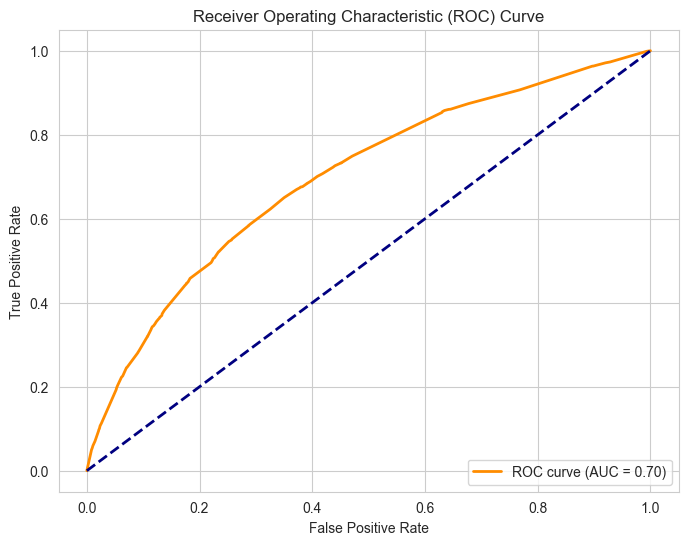

0.3962230187266522

In [17]:
pred = logit_model.predict(test_prepared)
fpr, tpr, thresholds = roc_curve(test_prepared["TARGET"],pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

In [18]:
confusion_matrix(test_prepared["TARGET"], np.round(pred))

array([[23788,     0],
       [ 2319,     0]])

# Grille de score

In [19]:
GS = GridScore(train_prepared, logit_model)
grid_score = GS.compute_grid_score()

In [20]:
grid_score

,Variable,Modality,Coefficient,P-Value,Score,Contribution,Pcentage_Défaut,Pcentage_Classe
0,Intercept,-,-3.792699,0.0,0.000000,0.0,0.00,0.00
1,AMT_CREDIT_SUM_DEBT_disc_int,[-1083614.67;36746.34]_ref,0.000000,0.0,106.109325,11.0,2.24,39.11
2,AMT_CREDIT_SUM_DEBT_disc_int,[36747.0;43650000.0],0.330000,0.0,0.000000,11.0,5.32,60.89
3,AMT_CREDIT_SUM_disc_int,[619038.0;198072344.25]_ref,0.000000,0.0,80.385852,9.0,0.68,11.94
4,AMT_CREDIT_SUM_disc_int,[0.0;619036.2],0.250000,0.0,0.000000,9.0,6.88,88.06
5,EXT_SOURCE_2_disc_int,[0.46;0.85]_ref,0.000000,0.0,202.572347,19.0,3.55,67.42
6,EXT_SOURCE_2_disc_int,[0.0;0.16],0.630000,0.0,0.000000,19.0,1.20,6.04
7,EXT_SOURCE_2_disc_int,[0.16;0.46],0.340000,0.0,93.247588,19.0,2.81,26.54
8,EXT_SOURCE_1_disc_int,[0.41;0.96]_ref,0.000000,0.0,257.234727,24.0,3.52,67.78
9,EXT_SOURCE_1_disc_int,[0.0;0.16],0.800000,0.0,0.000000,24.0,1.32,6.73


## Calcul des scores individuels

In [21]:
df_score = GS.get_individual_score()

(array([ 5288.,  2844., 13104., 15912., 29356., 35590., 24933., 56844.,
        74579., 21550.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 <BarContainer object of 10 artists>)

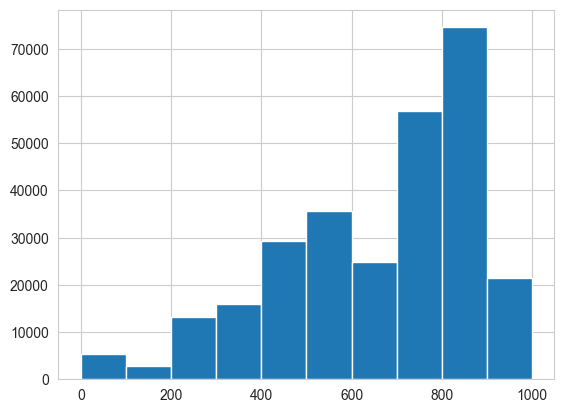

In [22]:
plt.hist(df_score["Score_ind"])

In [23]:
df_score.to_csv("../data/df_score.csv")